# RAG ile Başlarken

Büyük dil modelleri (LLM'ler) gelişmiş kullanım durumlarını destekleyen güçlü yetenekler gösterse de, olgusal tutarsızlık ve halüsinasyon gibi sorunlardan muzdariptirler. Retrieval-augmented generation (RAG), LLM yeteneklerini zenginleştirmek ve güvenilirliklerini artırmak için güçlü bir yaklaşımdır. RAG, bir görevi başarmaya yardımcı olan ilgili bilgilerle prompt bağlamını zenginleştirerek LLM'leri harici bilgiyle birleştirmeyi içerir.

Bu eğitim, vektör deposu ve açık kaynaklı LLM'lerden yararlanarak RAG ile nasıl başlayabileceğinizi gösterir. RAG'ın gücünü sergilemek için, bu kullanım durumu orijinal ML makale başlıklarından kısa ve okunması kolay ML makale başlıkları öneren bir RAG sistemi oluşturmayı kapsayacaktır. Makale başlıkları genel bir kitle için çok teknik olabilir, bu nedenle daha önce oluşturulmuş kısa başlıklara dayalı kısa başlıklar oluşturmak için RAG kullanmak, araştırma makalesi başlıklarını daha erişilebilir hale getirebilir ve haber bültenleri veya bloglar gibi bilimsel iletişim için kullanılabilir hale getirebilir.

Bu teknik, **bağlamın bir parçası olarak sağlanan ek bilgilerin** kullanılmasıyla, özellikle **gündelik akıl yürütme (commonsense reasoning)** gibi karmaşık görevlerde sonuçları iyileştirmeyi amaçlar.

* Bağlamda kullanılan bilgi, bir **model tarafından üretilir** ve tahmin yapmak için prompt’a dahil edilir.
* **En yüksek güvene sahip tahmin (highest-confidence prediction)** kullanılır.

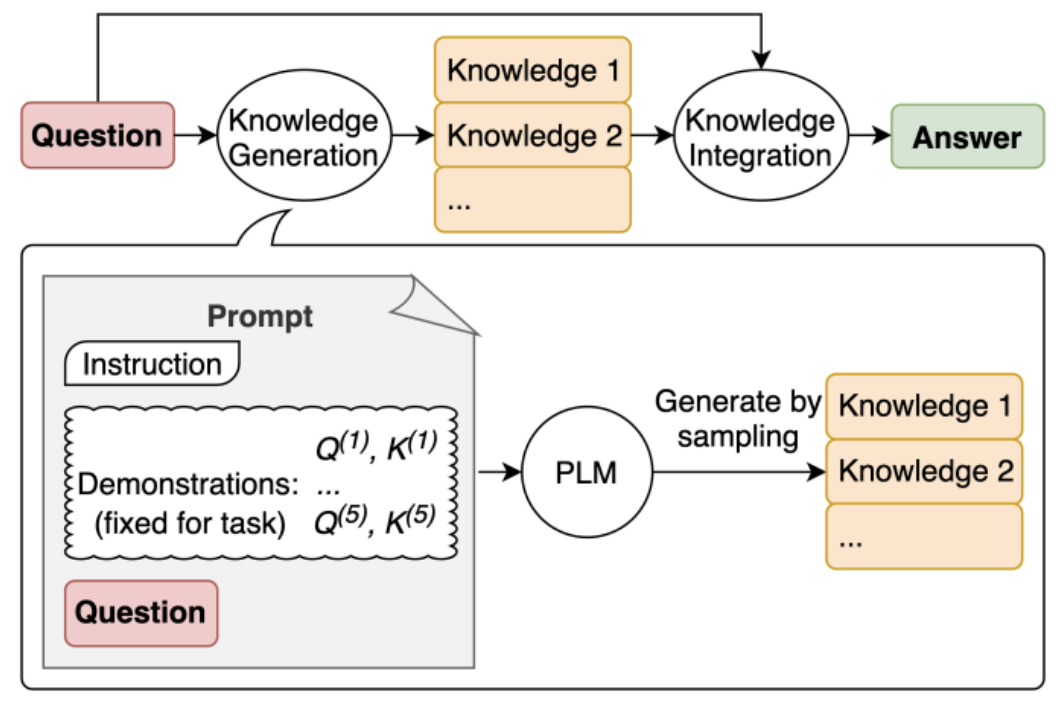

Başlamadan önce ilk olarak kullanacağım kütüphaneleri indirelim:

In [27]:
!pip install chromadb tqdm openai python-dotenv pandas

Devam etmeden önce, OpenAI chat ve embedding modelini kullanabilmek için bir OpenAI API Anahtarı (API Key) edinmeniz gerekmektedir.

OpennaI API anahtarınızı almak için bu hızlı rehbere göz atabilirsiniz:
🔗 https://platform.openai.com/docs/libraries?desktop-os=macOS#create-and-export-an-api-key

In [28]:
import os
import dotenv
import openai
import openai
import chromadb
import pandas as pd
import random
from tqdm.auto import tqdm

# Ortam değişkenlerinden key'i çekiyoruz
dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

COLLECTION_NAME = "ml-papers-nov-2023"

openai.Client(timeout=60)

## Hadi Başlayalım 👨🏻‍💻

Haydi, **OpenAI**ndan tamamlamalar (completions) almak için bir fonksiyon tanımlayalım.

In [3]:
def get_completion(prompt, model="gpt-3.5-turbo", max_tokens=200):
    """
    Bir promptu OpenAI ChatCompletion uç noktasina (endpoint) gönderir.
    """
    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=0
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {e}"

In [4]:
def get_openai_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model
    )
    return response.data[0].embedding


In [5]:
# OpenAI embedding fonksiyonu
def get_openai_embedding_batch(texts, model="text-embedding-3-small"):
    """
    Bir dizi string için OpenAI Embedding API (v1+) kullanarak embedding'leri döndürür.
    """
    response = openai.embeddings.create(
        input=texts,
        model=model
    )
    return [item.embedding for item in response.data]

Öncelikle fonksiyonu basit bir prompt ile default (GPT-3.5) model ile deneyelim:

In [29]:
get_completion("The weather is ")

'How can I assist you with the weather?'

Şimdi daha güncel bir dil modeli olan GPT4o modeli ile deneyelim:

In [30]:
model = "gpt-4o"

get_completion("The weather is ", model=model)

'Could you please provide more details or specify a location and date for the weather information you need?'

In [31]:
model = "gpt-4.1"

get_completion("The weather is ", model=model)

'It looks like your message got cut off. Could you please provide more details or complete your question about the weather? I’m here to help!'

Now let's try with a more complex prompt that involves instructions:

In [32]:
prompt = """
Given the following wedding guest data, write a very short 3-sentence thank you letter:

{
  "name": "John Doe",
  "relationship": "Bride's cousin",
  "hometown": "New York, NY",
  "fun_fact": "Climbed Mount Everest in 2020",
  "attending_with": "Sophia Smith",
  "bride_groom_name": "Tom and Mary"
}

Use only the data provided in the JSON object above.

The senders of the letter are the bride and groom, Tom and Mary.
"""

get_completion(prompt)

"Dear John Doe,\n\nThank you for joining us at our wedding celebration. It was wonderful to have you there as the bride's cousin all the way from New York, NY. We were truly impressed to learn about your incredible achievement of climbing Mount Everest in 2020. We hope you had a great time at the wedding with Sophia Smith.\n\nWarm regards,\nTom and Mary"

## RAG Kullanım Senaryosu: Kısa Makale Başlıkları Üretme

RAG (Retrieval-Augmented Generation) kullanım senaryosu için, haftalık en çok ilgi gören makaleleri içeren bir [veri kümesini](https://github.com/dair-ai/ML-Papers-of-the-Week/tree/main/research) kullanacağız.

Kullanıcı, orijinal bir makale başlığı sağlayacak. Biz de bu girdiyi alıp, veri kümesini kullanarak kısa ve akılda kalıcı makale başlıklarından oluşan bir bağlam (context) oluşturacağız. Bu bağlam, verilen orijinal başlık için dikkat çekici yeni bir başlık üretmeye yardımcı olacak.

### Adım 1: Verilerin Yüklenmesi

İlk olarak kullanacağımız verileri yükleyelim:

In [33]:
ml_papers = pd.read_csv("data/ml-potw-10232023.csv", header=0)
ml_papers = ml_papers.dropna(subset=["Title", "Description"])
ml_papers_dict = ml_papers.to_dict(orient="records")

In [34]:
ml_papers.head()

,Title,Description,PaperURL,TweetURL,Abstract
0,Llemma,an LLM for mathematics which is based on conti...,https://arxiv.org/abs/2310.10631,https://x.com/zhangir_azerbay/status/171409802...,"We present Llemma, a large language model for ..."
1,LLMs for Software Engineering,a comprehensive survey of LLMs for software en...,https://arxiv.org/abs/2310.03533,https://x.com/omarsar0/status/1713940983199506...,This paper provides a survey of the emerging a...
2,Self-RAG,presents a new retrieval-augmented framework t...,https://arxiv.org/abs/2310.11511,https://x.com/AkariAsai/status/171511027707796...,"Despite their remarkable capabilities, large l..."
3,Retrieval-Augmentation for Long-form Question ...,explores retrieval-augmented language models o...,https://arxiv.org/abs/2310.12150,https://x.com/omarsar0/status/1714986431859282...,We present a study of retrieval-augmented lang...
4,GenBench,presents a framework for characterizing and un...,https://www.nature.com/articles/s42256-023-007...,https://x.com/AIatMeta/status/1715041427283902...,NaN


In [35]:
ml_papers_dict[0]

{'Title': 'Llemma',
 'Description': 'an LLM for mathematics which is based on continued pretraining from Code Llama on the Proof-Pile-2 dataset; the dataset involves scientific paper, web data containing mathematics, and mathematical code; Llemma outperforms open base models and the unreleased Minerva on the MATH benchmark; the model is released, including dataset and code to replicate experiments.',
 'PaperURL': 'https://arxiv.org/abs/2310.10631',
 'TweetURL': 'https://x.com/zhangir_azerbay/status/1714098025956864031?s=20',
 'Abstract': 'We present Llemma, a large language model for mathematics. We continue pretraining Code Llama on the Proof-Pile-2, a mixture of scientific papers, web data containing mathematics, and mathematical code, yielding Llemma. On the MATH benchmark Llemma outperforms all known open base models, as well as the unreleased Minerva model suite on an equi-parameter basis. Moreover, Llemma is capable of tool use and formal theorem proving without any further finet

Embedding’leri oluşturmak için **OpenAI Embedding Func** kullanacağız ve bu embedding’leri bir **Chroma belge deposuna (document store)** kaydedeceğiz.

In [36]:
# ChromaDB EmbeddingFunction
from chromadb.api.types import Documents, Embeddings
from chromadb import EmbeddingFunction

class OpenAIEmbeddingFunction(EmbeddingFunction):
    def __init__(self, model_name="text-embedding-3-small"):
        self.model_name = model_name
    def __call__(self, input: Documents) -> Embeddings:
        return get_openai_embedding_batch(input, model=self.model_name)

embed_fn = OpenAIEmbeddingFunction()

client = chromadb.PersistentClient(path="./chromadb")

# Son kalan koleksiyonları da sil (güvenlik için tekrar)
for c in client.list_collections():
    client.delete_collection(name=c.name)

# Temiz koleksiyon oluştur
collection = client.get_or_create_collection(
    name=COLLECTION_NAME,
    embedding_function=embed_fn
)

Şimdi embedding’leri **batch’ler (küme/grup halinde)** oluşturacağız, burada amacımız bir bilgi darcığı oluşturmak.

In [37]:
# Embedding’leri oluştur ve başlıkları batch’ler halinde dizine ekle (indexle).
batch_size = 10  # ilk testte küçük tut
# Batch'ler üzerinde döngü yaparak embedding’leri oluştur ve depola.
for i in tqdm(range(0, len(ml_papers_dict), batch_size)):
    batch = ml_papers_dict[i:i + batch_size]
    # Başlık boş bir string ise, `"No Title"` ile değiştir.
    batch_titles = [str(p["Title"]) if p["Title"] else "No Title" for p in batch]
    batch_ids = [
        str(sum(ord(c) + random.randint(1, 10000) for c in p["Title"]))
        for p in batch
    ]
    # embeddingleri üret
    batch_embeddings = get_openai_embedding_batch(batch_titles, model="text-embedding-3-small")
    
    # ChromaDB’ye **upsert** (güncelle veya ekle) işlemini gerçekleştir.
    collection.upsert(
        ids=batch_ids,
        documents=batch_titles,
        embeddings=batch_embeddings,
    )

100%|██████████| 42/42 [00:28<00:00,  1.49it/s]


Artık retriver aşamasını test edebiliriz, yani sorgularımıza uygun embeddingleri getirecek ve bunları sorgulara ekleyerek bilgi ile beslenmiş net cevaplar alacağız.

In [15]:
# Benzer başlıkları sorgula
retriever_results = collection.query(
    query_texts=["Software Engineering"],
    n_results=2,
)

print("Retriever Results:", retriever_results["documents"])

Retriever Results: [['LLMs for Software Engineering', 'Communicative Agents for Software Development']]


Son olarak yukarıda bahsettiğimiz gibi elde edilen bilgileri ve sorguyu birlikte LLM'e veriyoruz.

In [16]:
# Öneriler için RAG tarzı prompt
user_query = "S3Eval: A Synthetic, Scalable, Systematic Evaluation Suite for Large Language Models"
results = collection.query(
    query_texts=[user_query],
    n_results=10,
)

short_titles = '\n'.join(results['documents'][0])

prompt_template = f"""
Your main task is to generate 5 SUGGESTED_TITLES for the PAPER_TITLE below.

You should mimic the style and length of the SHORT_TITLES, but do NOT repeat or include them. Only generate creative variations of the PAPER_TITLE.

PAPER_TITLE: {user_query}

SHORT_TITLES:
{short_titles}

SUGGESTED_TITLES:
"""

suggested_titles = get_completion(prompt_template, max_tokens=300)
print("Model Suggestions:\n", suggested_titles)
print("\nPrompt Template:\n", prompt_template)

Model Suggestions:
 1. SynthEval: An Extensive, Expandable Evaluation Framework for Massive Language Models
2. ScaleSynth: A Comprehensive, Scalable Assessment Suite for Extensive Language Models
3. SystematicLang: A Structured, Sizeable Evaluation Platform for Robust Language Models
4. MegaEval: A Robust, Resizable Evaluation Suite for Advanced Language Models
5. LangScale: A Comprehensive, Customizable Evaluation Suite for Vast Language Models

Prompt Template:
 
Your main task is to generate 5 SUGGESTED_TITLES for the PAPER_TITLE below.

You should mimic the style and length of the SHORT_TITLES, but do NOT repeat or include them. Only generate creative variations of the PAPER_TITLE.

PAPER_TITLE: S3Eval: A Synthetic, Scalable, Systematic Evaluation Suite for Large Language Models

SHORT_TITLES:
A Survey of Large Language Models
Pythia: A Suite for Analyzing Large Language Models Across Training and Scaling
Auditing large language models: a three-layered approach
Large Language and S

Görüldüğü üzere, LLM tarafından üretilen kısa başlıklar kısmen başarılı. Ancak bu kullanım senaryosu hâlâ önemli ölçüde geliştirme gerektiriyor ve muhtemelen **fine-tuning** işleminden de fayda sağlayabilir.

Bu eğitimin amacı doğrultusunda, **OpenAI’ın son derece hızlı modellerini** kullanılarak oluşturulmuş basit bir RAG uygulaması sunduk.

Hadi şimdi daha da kişiselleştirilmiş bir uygulamayladevam edelim ve kişisel LınkedIn hesabımızın pdf halini vererek LLM'ni bizim hakkımızdaki bilgileri yanıtlamasını sağlayalım.

Bu çok güzel ve gerçek hayat için oldukça faydalı bir RAG (Retrieval-Augmented Generation) uygulamasıdır. 
Uygulama adımlarımız aşağıdaki gibi olacak:

1. LinkedIn Verini Çek (LinkedIn profilini PDF olarak indir) -> PyPDF ile işleyeceğiz.

2. Verini Metne (veya JSON'a) Dönüştür

3. RAG Pipeline’a Kendi Verini Besle

4. Kullanıcıdan soru al.

5. Benzer bilgiyi bul (ChromaDB query ile).

6. ChatGPT’ye context + soruyu gönder.

7. Cevabı üret ve kullanıcıya göster.

In [38]:
!pip3 install PyPDF2


In [39]:
from PyPDF2 import PdfReader

# ChromaDB'yi %100 temiz başlat
# shutil.rmtree('./chromadb', ignore_errors=True)
# client = chromadb.PersistentClient(path="./chromadb")

# PDF'den metni çıkar
pdf_path = "data/Profile.pdf"
reader = PdfReader(pdf_path)
profile_text = ""
for page in reader.pages:
    profile_text += page.extract_text() + "\n"

In [40]:
# Koleksiyonu oluştur
collection = client.get_or_create_collection(
    name="personal-profile",
    embedding_function=embed_fn
)

# Profil metnini indexe ekle
collection.upsert(
    ids=["profile1"],
    documents=[profile_text],
    embeddings=get_openai_embedding_batch([profile_text])
)

In [41]:

user_query = "Kubilay Tuna'nın uzmanlık alanları nelerdir?"
results = collection.query(query_texts=[user_query], n_results=1) # retrive et
context = results['documents'][0][0]

prompt = f"""
Aşağıda Kubilay Tuna'nın LinkedIn profilinden alınan bilgiler var:

{context}

Soru: {user_query}

Bilgiye dayalı kısa, açık ve profesyonel bir cevap üret.
"""

answer = get_completion(prompt)
print("YANIT:", answer)

YANIT: Kubilay Tuna'nın uzmanlık alanları arasında Computer Vision (CV), Natural Language Processing (NLP), Generative AI (GenAI), Agents, Large Language Model Operations (LLMOps), Prompt Engineering, MLOps, Geospatial AI ve Leadership & Mentorship bulunmaktadır.


Hadi şimdi bunu interaktif bir chat döngüsünde gerçekleştirelim 🙃

In [42]:
user_query = ""

while True:
    user_query = input("Soru sor (çıkmak için q yaz): ")
    if user_query.lower().strip() == "q":
        print("Sohbet sonlandırıldı.")
        break

    # RAG: En uygun bölümü bul
    results = collection.query(query_texts=[user_query], n_results=1)
    context = results['documents'][0][0]

    # Prompta context ile soruyu birleştir
    prompt = f"""
    Aşağıda Kubilay Tuna'nın LinkedIn profilinden alınan bilgiler var:

    {context}

    Soru: {user_query}

    Bilgiye dayalı kısa, açık ve profesyonel bir cevap üret. Sorulmadıkça Kubilay hakkında bilgi paylaşma.
    """

    # Yanıtla
    model = "gpt-4o"
    answer = get_completion(prompt, model=model)
    print("\nYANIT:", answer)
    print("-" * 60)



YANIT: Merhaba! Size nasıl yardımcı olabilirim?
------------------------------------------------------------

YANIT: Hayır, Kubilay Tuna'yı kişisel olarak tanımıyorum. Ancak, LinkedIn profilinden elde edilen bilgilere göre, kendisi deneyimli bir Makine Öğrenimi Mühendisi ve Veri Bilimcisi olarak EPAM Systems'ta çalışmaktadır. Profesyonel kariyerinde yapay zeka, bilgisayarla görme ve doğal dil işleme gibi alanlarda uzmanlaşmıştır.
------------------------------------------------------------

YANIT: Kubilay'ın profesyonel deneyimi, 2019 yılında InfoDif'te çalışmaya başlamasından itibaren hesaplanabilir. 2023 yılı itibarıyla yaklaşık 4 yıllık bir profesyonel deneyime sahiptir.
------------------------------------------------------------

YANIT: Kubilay Tuna, toplamda 6 yılı aşkın bir profesyonel deneyime sahiptir.
------------------------------------------------------------
Sohbet sonlandırıldı.
